### 4. Now we want to build a model to truly graps the intearction between Cubee and the survival 
- We're assuming no direct link between Cubee and the survival but rather impact on the hive state and attribute leading to 
increase survival probability.

Therefore a BayesianNetwork suit well our problem since we have knowledge about the impact of cubee on the colonies attributes. We can do paramters learn on our data from a biologically relevant network. 

In [729]:
from pgmpy.models import DiscreteBayesianNetwork
from IPython.display import Image
from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import TreeSearch
from pgmpy.sampling import BayesianModelSampling
from scipy.stats import gmean
import itertools
import networkx as nx
import math 
import pprint

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

from cubee.configs.filepath import formatted_datapath, raw_datapath

from pgmpy.inference import VariableElimination
import time

In [732]:
data = pd.read_csv(formatted_datapath)
data['death'] = data["state"].apply(lambda x: True if x < 1 else False)
ROLLING_CUBEE_MONTH = 3
data['cubee'] = data.groupby("hid")['cubee'].rolling(ROLLING_CUBEE_MONTH).sum().reset_index()['cubee']
data['cubee'] = data['cubee'].fillna(0)


data['fob'] = data.groupby("hid")['fob'].ffill(ROLLING_CUBEE_MONTH)
data['fob'] = data.groupby("hid")['fob'].rolling(ROLLING_CUBEE_MONTH).mean().reset_index()['fob']
data['fobr'] = data.groupby("hid")['fobr'].ffill(ROLLING_CUBEE_MONTH)
data['fobr'] = data.groupby("hid")['fobr'].rolling(ROLLING_CUBEE_MONTH).mean().reset_index()['fobr']
data['varroa'] = data.groupby("hid")['varroa'].ffill(ROLLING_CUBEE_MONTH)
data['varroa'] = data.groupby("hid")['varroa'].rolling(ROLLING_CUBEE_MONTH).mean().reset_index()['varroa']
data['brood_pattern'] = data.groupby("hid")['brood_pattern'].ffill(ROLLING_CUBEE_MONTH)
data['brood_pattern'] = data.groupby("hid")['brood_pattern'].rolling(ROLLING_CUBEE_MONTH).mean().reset_index()['brood_pattern']
data.tail()

,time1,time2,state,hive_age,cubee,fob,fobr,foh,varroa,queen_age,queen_state,queen_id,brood_pattern,stings,hid,hive_interacted,death
2843,29,59,1,32,0.0,NaN,NaN,NaN,NaN,32.0,False,664202_queen_0,NaN,0.0,664202,31,False
2844,0,29,1,0,0.0,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,NaN,665047,34,False
2845,29,59,1,30,0.0,NaN,NaN,NaN,NaN,30.0,False,665047_queen_0,NaN,NaN,665047,31,False
2846,0,29,1,3,0.0,NaN,NaN,2.0,NaN,3.0,False,665312_queen_0,NaN,0.0,665312,9,False
2847,29,59,1,38,0.0,NaN,NaN,2.0,NaN,38.0,False,665312_queen_0,NaN,0.0,665312,9,False


In [783]:
cubee_model = DiscreteBayesianNetwork([ 
                                        ('fob', 'varroa'),
                                        ('cubee', 'fobr'),
                                        ('cubee', 'fob'),
                                        ('cubee', 'queen_age'),
                                        ('cubee', 'death'),  
                                        ('varroa', 'death'),
                                        ('fob', 'death'),
                                        ('fobr', 'death'),
                                        ('queen_age', 'fobr'),
                                        ('fobr', 'varroa'),
                                        ('hive_interacted','varroa'),
                                        ('queen_age', 'varroa'),
                                        # ('hive_age','death'),
                                         
                                      ])

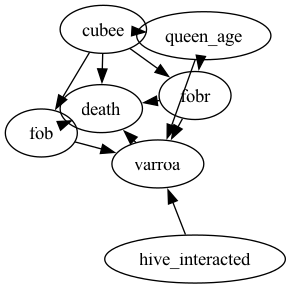

In [784]:
viz = cubee_model.to_graphviz()
viz.draw('cubee_model.png', prog='neato')
Image('cubee_model.png')

In [785]:
def grade(x):
    if x < 8:
        return 'weak'
    elif (x >= 8) and (x <= 12):
        return 'medium'
    else:
        return 'strong'

In [786]:
def grade_fobr(x):
    if x <= 2:
        return 'weak'
    elif (x > 2) and (x <= 6):
        return 'medium'
    else:
        return 'strong'

In [787]:
def density(x):
    if x < 8:
        return 'low'
    elif (x >= 8) and (x <= 16):
        return 'medium'
    else:
        return 'high'

In [788]:
samples = data[['varroa', 'death', 'fob','fobr','hive_interacted', 'queen_age', 'hive_age', 'cubee','hid']]
samples['varroa'] = samples['varroa'].apply(lambda x: "over threshold" if x >= 3 else "healthy")
samples['fob'] = samples['fob'].apply(lambda x: grade(x))
samples['fobr'] = samples['fobr'].apply(lambda x: grade_fobr(x))
samples['hive_interacted'] = samples['hive_interacted'].apply(lambda x: density(x))
def t(x):
    try: 
        return math.floor(x/365) + 1
    except:
        return None
samples['queen_age'] = samples['queen_age'].apply(lambda x:  t(x))
# samples['hive_age'] = samples['hive_age'].apply(lambda x: t(x))
samples['cubee'] = samples['cubee'].apply(lambda x: "cubeed" if x >0 else "control")
samples.tail(20)

/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_77486/1309936896.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples['varroa'] = samples['varroa'].apply(lambda x: "over threshold" if x >= 3 else "healthy")
/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_77486/1309936896.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples['fob'] = samples['fob'].apply(lambda x: grade(x))
/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_77486/1309936896.py:4: SettingWithCopyWarn

,varroa,death,fob,fobr,hive_interacted,queen_age,hive_age,cubee,hid
2828,healthy,False,medium,medium,high,1.0,64,control,631203
2829,healthy,False,strong,strong,low,NaN,0,control,639510
2830,healthy,False,strong,strong,low,NaN,35,control,639510
2831,healthy,False,medium,strong,low,NaN,53,control,639510
2832,healthy,False,strong,strong,low,NaN,0,control,639530
2833,healthy,False,strong,strong,low,NaN,18,control,639530
2834,healthy,False,strong,weak,low,NaN,53,control,639530
2835,healthy,False,strong,strong,low,NaN,0,control,639531
2836,healthy,False,strong,strong,low,NaN,35,control,639531
2837,healthy,False,strong,medium,low,NaN,53,control,639531


In [789]:

pe = ParameterEstimator(cubee_model, samples)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'varroa': 'C', 'death': 'N', 'fob': 'C', 'fobr': 'C', 'hive_interacted': 'C', 'queen_age': 'N', 'hive_age': 'N', 'cubee': 'C', 'hid': 'N'}


In [790]:
print("\n", pe.state_counts('cubee'))


          count
cubee         
control   1869
cubeed     979


In [791]:

# Access attributes of the model
nodes = cubee_model.nodes()
edges = cubee_model.edges()
cpds = cubee_model.get_cpds()

print(f"Nodes in the model: {nodes} \n")
print(f"Edges in the model: {edges} \n")
print(f"CPDs in the model: ")
print(cpds)

Nodes in the model: ['fob', 'varroa', 'cubee', 'fobr', 'queen_age', 'death', 'hive_interacted'] 

Edges in the model: [('fob', 'varroa'), ('fob', 'death'), ('varroa', 'death'), ('cubee', 'fobr'), ('cubee', 'fob'), ('cubee', 'queen_age'), ('cubee', 'death'), ('fobr', 'death'), ('fobr', 'varroa'), ('queen_age', 'fobr'), ('queen_age', 'varroa'), ('hive_interacted', 'varroa')] 

CPDs in the model: 
[]


In [792]:

mle_est = MaximumLikelihoodEstimator(model=cubee_model, data=samples)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'varroa': 'C', 'death': 'N', 'fob': 'C', 'fobr': 'C', 'hive_interacted': 'C', 'queen_age': 'N', 'hive_age': 'N', 'cubee': 'C', 'hid': 'N'}


In [793]:
print(mle_est.estimate_cpd(node="cubee"))

+----------------+---------+
| cubee(control) | 0.65625 |
+----------------+---------+
| cubee(cubeed)  | 0.34375 |
+----------------+---------+


In [794]:

# from IPython.core.display import display, HTML

# disable text wrapping in output cell
# display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

cubee_model.cpds = []
cubee_model.fit(data=samples, 
          estimator=BayesianEstimator,
          prior_type="BDeu",
               equivalent_sample_size=10)

print(f'Check model: {cubee_model.check_model()}\n')
for cpd in cubee_model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'varroa': 'C', 'death': 'N', 'fob': 'C', 'fobr': 'C', 'hive_interacted': 'C', 'queen_age': 'N', 'hive_age': 'N', 'cubee': 'C', 'hid': 'N'}


Check model: True

CPT of fob:
+-------------+---------------------+---------------------+
| cubee       | cubee(control)      | cubee(cubeed)       |
+-------------+---------------------+---------------------+
| fob(medium) | 0.1599075062255425  | 0.2018970189701897  |
+-------------+---------------------+---------------------+
| fob(strong) | 0.6855211668445392  | 0.5199864498644987  |
+-------------+---------------------+---------------------+
| fob(weak)   | 0.15457132692991818 | 0.27811653116531165 |
+-------------+---------------------+---------------------+ 

CPT of varroa:
+------------------------+-----+-------------------------+
| fob                    | ... | fob(weak)               |
+------------------------+-----+-------------------------+
| fobr                   | ... | fobr(weak)              |
+------------------------+-----+-------------------------+
| hive_interacted        | ... | hive_interacted(medium) |
+------------------------+-----+-------------------------+

In [795]:
# print(f'There can be made {len(cubee_model.get_independencies().get_assertions())}',
#       'valid independence assertions with respect to the all possible given evidence.')
# print('For instance, any node in the network is independent of its non-descendents given its parents (local semantics):\n',
#       f'\n{model.local_independencies(nodes)}\n')

def active_trails_of(query, evidence):
    active = cubee_model.active_trail_nodes(query, observed=evidence).get(query)
    active.remove(query)
    if active:
        if evidence:
            print(f'Active trails between \'{query}\' and {active} given the evidence {set(evidence)}.')
        else:
            print(f'Active trails between \'{query}\' and {active} given no evidence.')
    else:
        print(f'No active trails for \'{query}\' given the evidence {set(evidence)}.')
        
def markov_blanket_of(node):
    print(f'Markov blanket of \'{node}\' is {set(cubee_model.get_markov_blanket(node))}')

active_trails_of(query='death', evidence=[])
active_trails_of(query='death', evidence=['cubee'])
active_trails_of(query='death', evidence=['cubee', 'varroa'])
active_trails_of(query='death', evidence=['cubee','fob','varroa'])
active_trails_of(query='varroa', evidence=['cubee', 'fob'])
print()
markov_blanket_of(node='fob')
markov_blanket_of(node='varroa')
markov_blanket_of(node='death')
markov_blanket_of(node='cubee') 

Active trails between 'death' and {'varroa', 'cubee', 'queen_age', 'fob', 'fobr', 'hive_interacted'} given no evidence.
Active trails between 'death' and {'varroa', 'queen_age', 'fob', 'fobr', 'hive_interacted'} given the evidence {'cubee'}.
Active trails between 'death' and {'queen_age', 'fob', 'fobr', 'hive_interacted'} given the evidence {'varroa', 'cubee'}.
Active trails between 'death' and {'fobr', 'queen_age', 'hive_interacted'} given the evidence {'varroa', 'cubee', 'fob'}.
Active trails between 'varroa' and {'queen_age', 'fobr', 'death', 'hive_interacted'} given the evidence {'cubee', 'fob'}.

Markov blanket of 'fob' is {'varroa', 'fobr', 'cubee', 'queen_age', 'death', 'hive_interacted'}
Markov blanket of 'varroa' is {'fobr', 'cubee', 'queen_age', 'fob', 'death', 'hive_interacted'}
Markov blanket of 'death' is {'fobr', 'varroa', 'cubee', 'fob'}
Markov blanket of 'cubee' is {'varroa', 'fobr', 'queen_age', 'fob', 'death'}


In [796]:


def query_report(infer, variables, evidence=None, elimination_order="MinFill", show_progress=False, desc=""):
    if desc:
        print(desc)
    start_time = time.time()
    print(infer.query(variables=variables, 
                      evidence=evidence, 
                      elimination_order=elimination_order, 
                      show_progress=show_progress))
    print(f'--- Query executed in {time.time() - start_time:0,.4f} seconds ---\n')
    
def get_ordering(infer, variables, evidence=None, elimination_order="MinFill", show_progress=False, desc=""):
    start_time = time.time()
    ordering = infer._get_elimination_order(variables=variables, 
                                        evidence=evidence, 
                                        elimination_order=elimination_order, 
                                        show_progress=show_progress)
    if desc:
        print(desc, ordering, sep='\n')
        print(f'--- Ordering found in {time.time() - start_time:0,.4f} seconds ---\n')
    return ordering

def padding(heuristic):
    return (heuristic + ":").ljust(16)

def compare_all_ordering(infer, variables, evidence=None, show_progress=False):
    ord_dict = {
        "MinFill": get_ordering(infer, variables, evidence, "MinFill", show_progress),
        "MinNeighbors": get_ordering(infer, variables, evidence, "MinNeighbors", show_progress),
        "MinWeight": get_ordering(infer, variables, evidence, "MinWeight", show_progress),
        "WeightedMinFill": get_ordering(infer, variables, evidence, "WeightedMinFill", show_progress)
    }
    if not evidence:
        pre = f'elimination order found for probability query of {variables} with no evidence:'
    else:
        pre = f'elimination order found for probability query of {variables} with evidence {evidence}:'
    if ord_dict["MinFill"] == ord_dict["MinNeighbors"] and ord_dict["MinFill"] == ord_dict["MinWeight"] and ord_dict["MinFill"] == ord_dict["WeightedMinFill"]:
        print(f'All heuristics find the same {pre}.\n{ord_dict["MinFill"]}\n')
    else:
        print(f'Different {pre}')
        for heuristic, order in ord_dict.items():
            print(f'{padding(heuristic)} {order}')
        print()
            
infer = VariableElimination(cubee_model)

var = ['death']
heuristic = "MinNeighbors"
ordering = get_ordering(infer, variables=var, elimination_order=heuristic,
                        desc=f'Elimination order for {var} with no evidence computed through {heuristic} heuristic:')
query_report(infer, variables=var, elimination_order=ordering, 
             desc=f'Probability query of {var} with no evidence through precomputed elimination order:') 
query_report(infer, variables=var, elimination_order=list(reversed(ordering)), 
             desc=f'Probability query of {var} with no evidence through dummy elimination order:')
compare_all_ordering(infer, variables=var)

var = ['death']
ev = {'cubee': "cubeed", "fob":"weak",'varroa':'over threshold'}
heuristic = "MinFill"
query_report(infer, variables=var, evidence=ev, elimination_order=heuristic, 
             desc=f'Probability query of {var} with evidence {ev} computed through {heuristic} heuristic:')
compare_all_ordering(infer, variables=var, evidence=ev)
heuristic = "MinNeighbors"
ev = {'cubee': "cubeed", "fob":"strong",'varroa':'healthy'}
query_report(infer, variables=var, evidence=ev, elimination_order=heuristic, 
             desc=f'Probability query of {var} with evidence {ev} computed through {heuristic} heuristic:') 

heuristic = "MinNeighbors"
ev = {'cubee': "control", "fob":"strong",'varroa':'healthy'}
query_report(infer, variables=var, evidence=ev, elimination_order=heuristic, 
             desc=f'Probability query of {var} with evidence {ev} computed through {heuristic} heuristic:') 

heuristic = "MinNeighbors"
ev = {'cubee': "control", "fob":"weak",'varroa':'over threshold'}
query_report(infer, variables=var, evidence=ev, elimination_order=heuristic, 
             desc=f'Probability query of {var} with evidence {ev} computed through {heuristic} heuristic:') 

heuristic = "MinNeighbors"
ev = {'cubee': "control", "fob":"weak",'varroa':'healthy',"hive_interacted":"high"}
query_report(infer, variables=var, evidence=ev, elimination_order=heuristic, 
             desc=f'Probability query of {var} with evidence {ev} computed through {heuristic} heuristic:') 

heuristic = "MinNeighbors"
ev = {'cubee': "cubeed", "fob":"weak",'varroa':'healthy',"hive_interacted":"high"}
query_report(infer, variables=var, evidence=ev, elimination_order=heuristic, 
             desc=f'Probability query of {var} with evidence {ev} computed through {heuristic} heuristic:') 

heuristic = "MinNeighbors"
ev = {'cubee': "control", "fob":"weak",'varroa':'healthy',"hive_interacted":"low"}
query_report(infer, variables=var, evidence=ev, elimination_order=heuristic, 
             desc=f'Probability query of {var} with evidence {ev} computed through {heuristic} heuristic:') 

heuristic = "MinNeighbors"
ev = {'cubee': "cubeed", "fob":"weak",'varroa':'healthy',"hive_interacted":"low"}
query_report(infer, variables=var, evidence=ev, elimination_order=heuristic, 
             desc=f'Probability query of {var} with evidence {ev} computed through {heuristic} heuristic:') 

Elimination order for ['death'] with no evidence computed through MinNeighbors heuristic:
['hive_interacted', 'queen_age', 'varroa', 'cubee', 'fob', 'fobr']
--- Ordering found in 0.0036 seconds ---

Probability query of ['death'] with no evidence through precomputed elimination order:
+--------------+--------------+
| death        |   phi(death) |
+==============+==============+
| death(False) |       0.9192 |
+--------------+--------------+
| death(True)  |       0.0808 |
+--------------+--------------+
--- Query executed in 0.0017 seconds ---

Probability query of ['death'] with no evidence through dummy elimination order:
+--------------+--------------+
| death        |   phi(death) |
+==============+==============+
| death(False) |       0.9192 |
+--------------+--------------+
| death(True)  |       0.0808 |
+--------------+--------------+
--- Query executed in 0.0028 seconds ---

Different elimination order found for probability query of ['death'] with no evidence:
MinFill:      

In [797]:
varroa_cpd = cubee_model.get_cpds()[2]
varroa_cpd.to_dataframe().reset_index().groupby(["cubee","varroa","fob"]).mean(numeric_only=True)

death                             False      True
cubee   varroa         fob                       
control healthy        medium  0.806805  0.193195
                       strong  0.919273  0.080727
                       weak    0.834626  0.165374
        over threshold medium  0.632442  0.367558
                       strong  0.635352  0.364648
                       weak    0.500650  0.499350
cubeed  healthy        medium  0.978970  0.021030
                       strong  0.995033  0.004967
                       weak    0.902679  0.097321
        over threshold medium  0.870198  0.129802
                       strong  0.889087  0.110913
                       weak    0.807423  0.192577

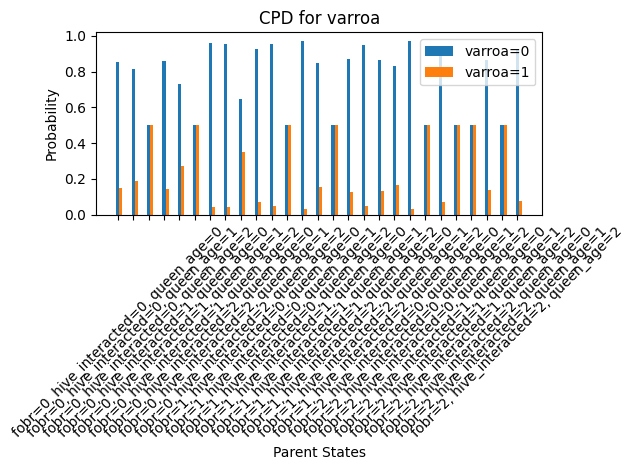

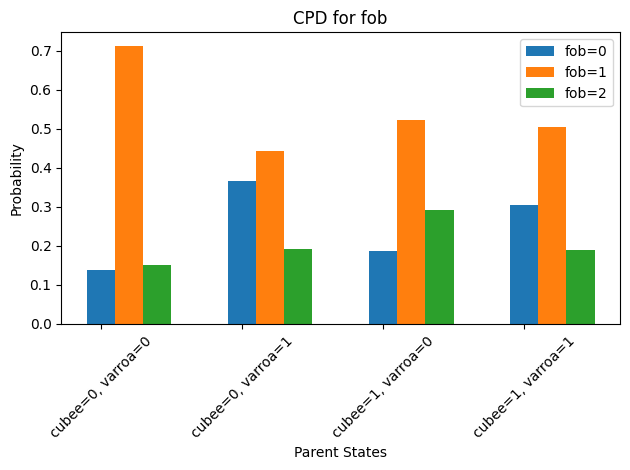

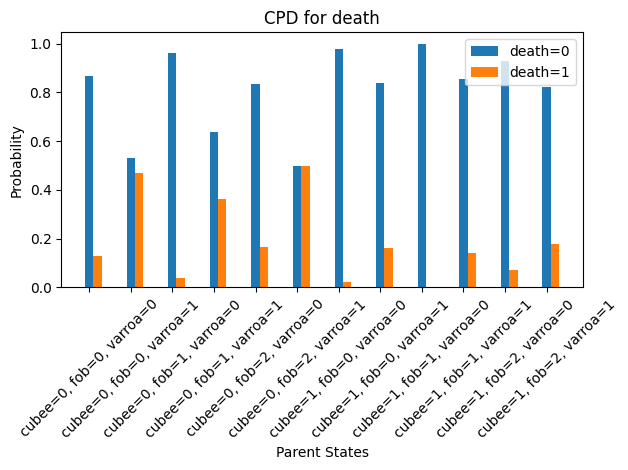

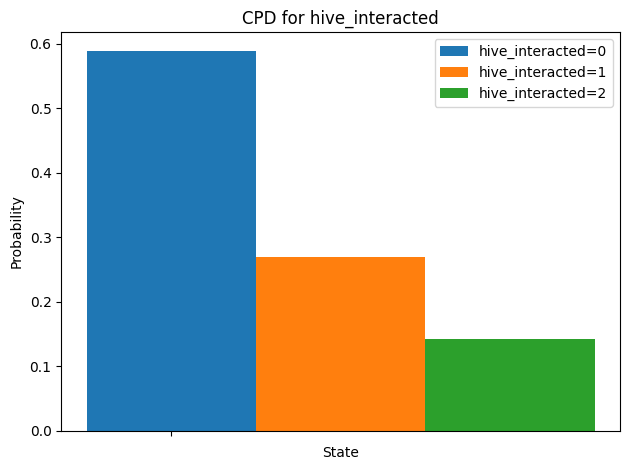

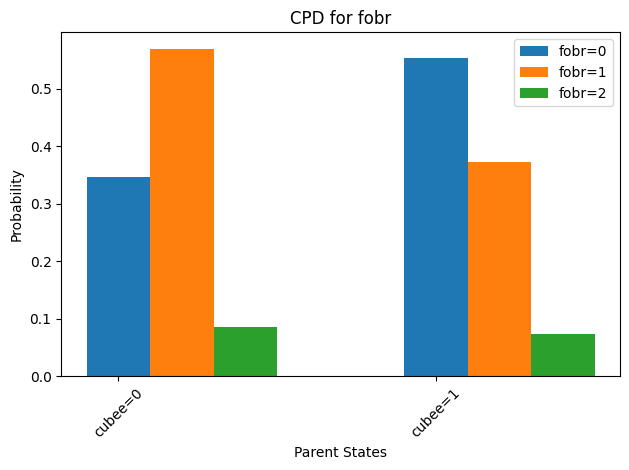

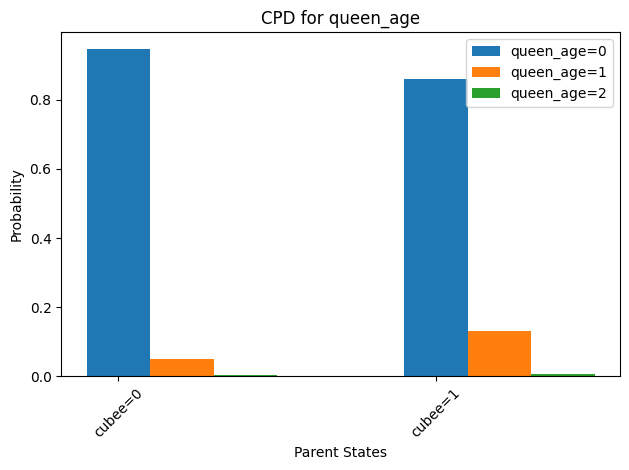

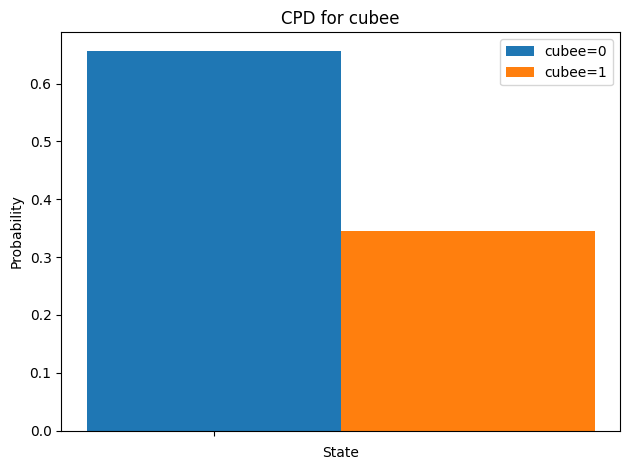

In [763]:
for cpd in cubee_model.get_cpds():
    plt.figure()
    var = cpd.variable
    evidence = cpd.variables[1:]
    
    # Generate evidence combinations
    if evidence:
        evidence_cards = cpd.cardinality[1:]
        combinations = list(itertools.product(*[range(c) for c in evidence_cards]))
        evidence_combinations = [", ".join(f"{e}={s}" for e,s in zip(evidence, c)) for c in combinations]
    else:
        evidence_combinations = ['']

    # Plot
    values = cpd.values if evidence else cpd.values.flatten()
    values = values.reshape(cpd.variable_card, -1) 
    x = np.arange(len(evidence_combinations))
    for i in range(values.shape[0]):
        plt.bar(x + i*0.2, values[i], 0.2, label=f"{var}={i}")
    plt.xticks(x, evidence_combinations, rotation=45)
    plt.xlabel("Parent States" if evidence else "State")
    plt.ylabel("Probability")
    plt.title(f"CPD for {var}")
    plt.legend()
    plt.tight_layout()